In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.linalg import eig
from scipy.sparse import spdiags
from scipy.linalg import solve
from scipy.linalg import lu
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import gmres
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2, ifft2
import matplotlib.animation as animation

In [2]:
# Setting spatial domain and time
N = 64
size = N*N
nu = 0.001
dt = 0.5
timespan = (0,4.5)
times = np.arange(0.0, 4.5, dt)
L = 10
span = np.linspace(-L, L, N+1)
x = span[0:N]
y = span[0:N]
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

In [3]:
# making A, B, C matrices
e0 = np.zeros((size, 1))  # vector of zeros
e1 = np.ones((size, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, N+1):
    e2[N*j-1] = 0  # overwrite every m^th value with zero
    e4[N*j-1] = 1  # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:size] = e2[0:size-1]
e3[0] = e2[size-1]

e5 = np.zeros_like(e4)
e5[1:size] = e4[0:size-1]
e5[0] = e4[size-1]

# Place diagonal elements
Adiagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
Aoffsets = [-(size-N), -N, -N+1, -1, 0, 1, N-1, N, (size-N)]

matA = spdiags(Adiagonals, Aoffsets, size, size).toarray()

A1 = (matA + np.zeros((N**2,N**2)))/(dx**2)

Bdiagonals = [e1.flatten(), -1*e1.flatten(), e1.flatten(), -1*e1.flatten()]
Boffsets = [-(size-N), -N, N, (size-N)]

matB = spdiags(Bdiagonals, Boffsets, size, size).toarray()

A2 = (matB + np.zeros((N**2,N**2)))/(2*dx)

e6 = np.copy(e1) # copy the one vector
e7 = np.copy(e1) # copy the one vector
e8 = np.copy(e0) # copy the zero vector
e9 = np.copy(e0) # copy the zero vector

for j in range(1, N):
    e6[N*j-1] = 0  # overwrite every m^th value with zero
    e7[N*j] = 0  # overwrite every m^th value with zero
    e8[N*j-1] = 1
    e9[N*j] = 1

e7[N*(N-1)] = 0
e8[-1] = 1
e9[0] = 1

Cdiagonals = [e9.flatten(), -1*e6.flatten(), e7.flatten(), -1*e8.flatten()]
Coffsets = [-(N-1), -1, 1, N-1]

matC = spdiags(Cdiagonals, Coffsets, size, size).toarray()

A3 = (matC + np.zeros((N**2,N**2)))/(2*dy)

In [4]:
A = A1
B = A2
C = A3

In [5]:
# Setting initial condition
sigmax = 1
sigmay = 4
omega0 = np.exp((-(X**2))-((Y**2)/20))
omega0flat = omega0.reshape(size)

In [5]:
#a

In [6]:
# Setting wave numbers for fft
kx = (2 * np.pi / L) * np.concatenate((np.arange(0, N/2), np.arange(-N/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / L) * np.concatenate((np.arange(0, N/2), np.arange(-N/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

/var/folders/0p/2d3480md4n57dj4kyxxyxq6h0000gn/T/ipykernel_38624/661685514.py:16: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, omegaia, shading='interp')


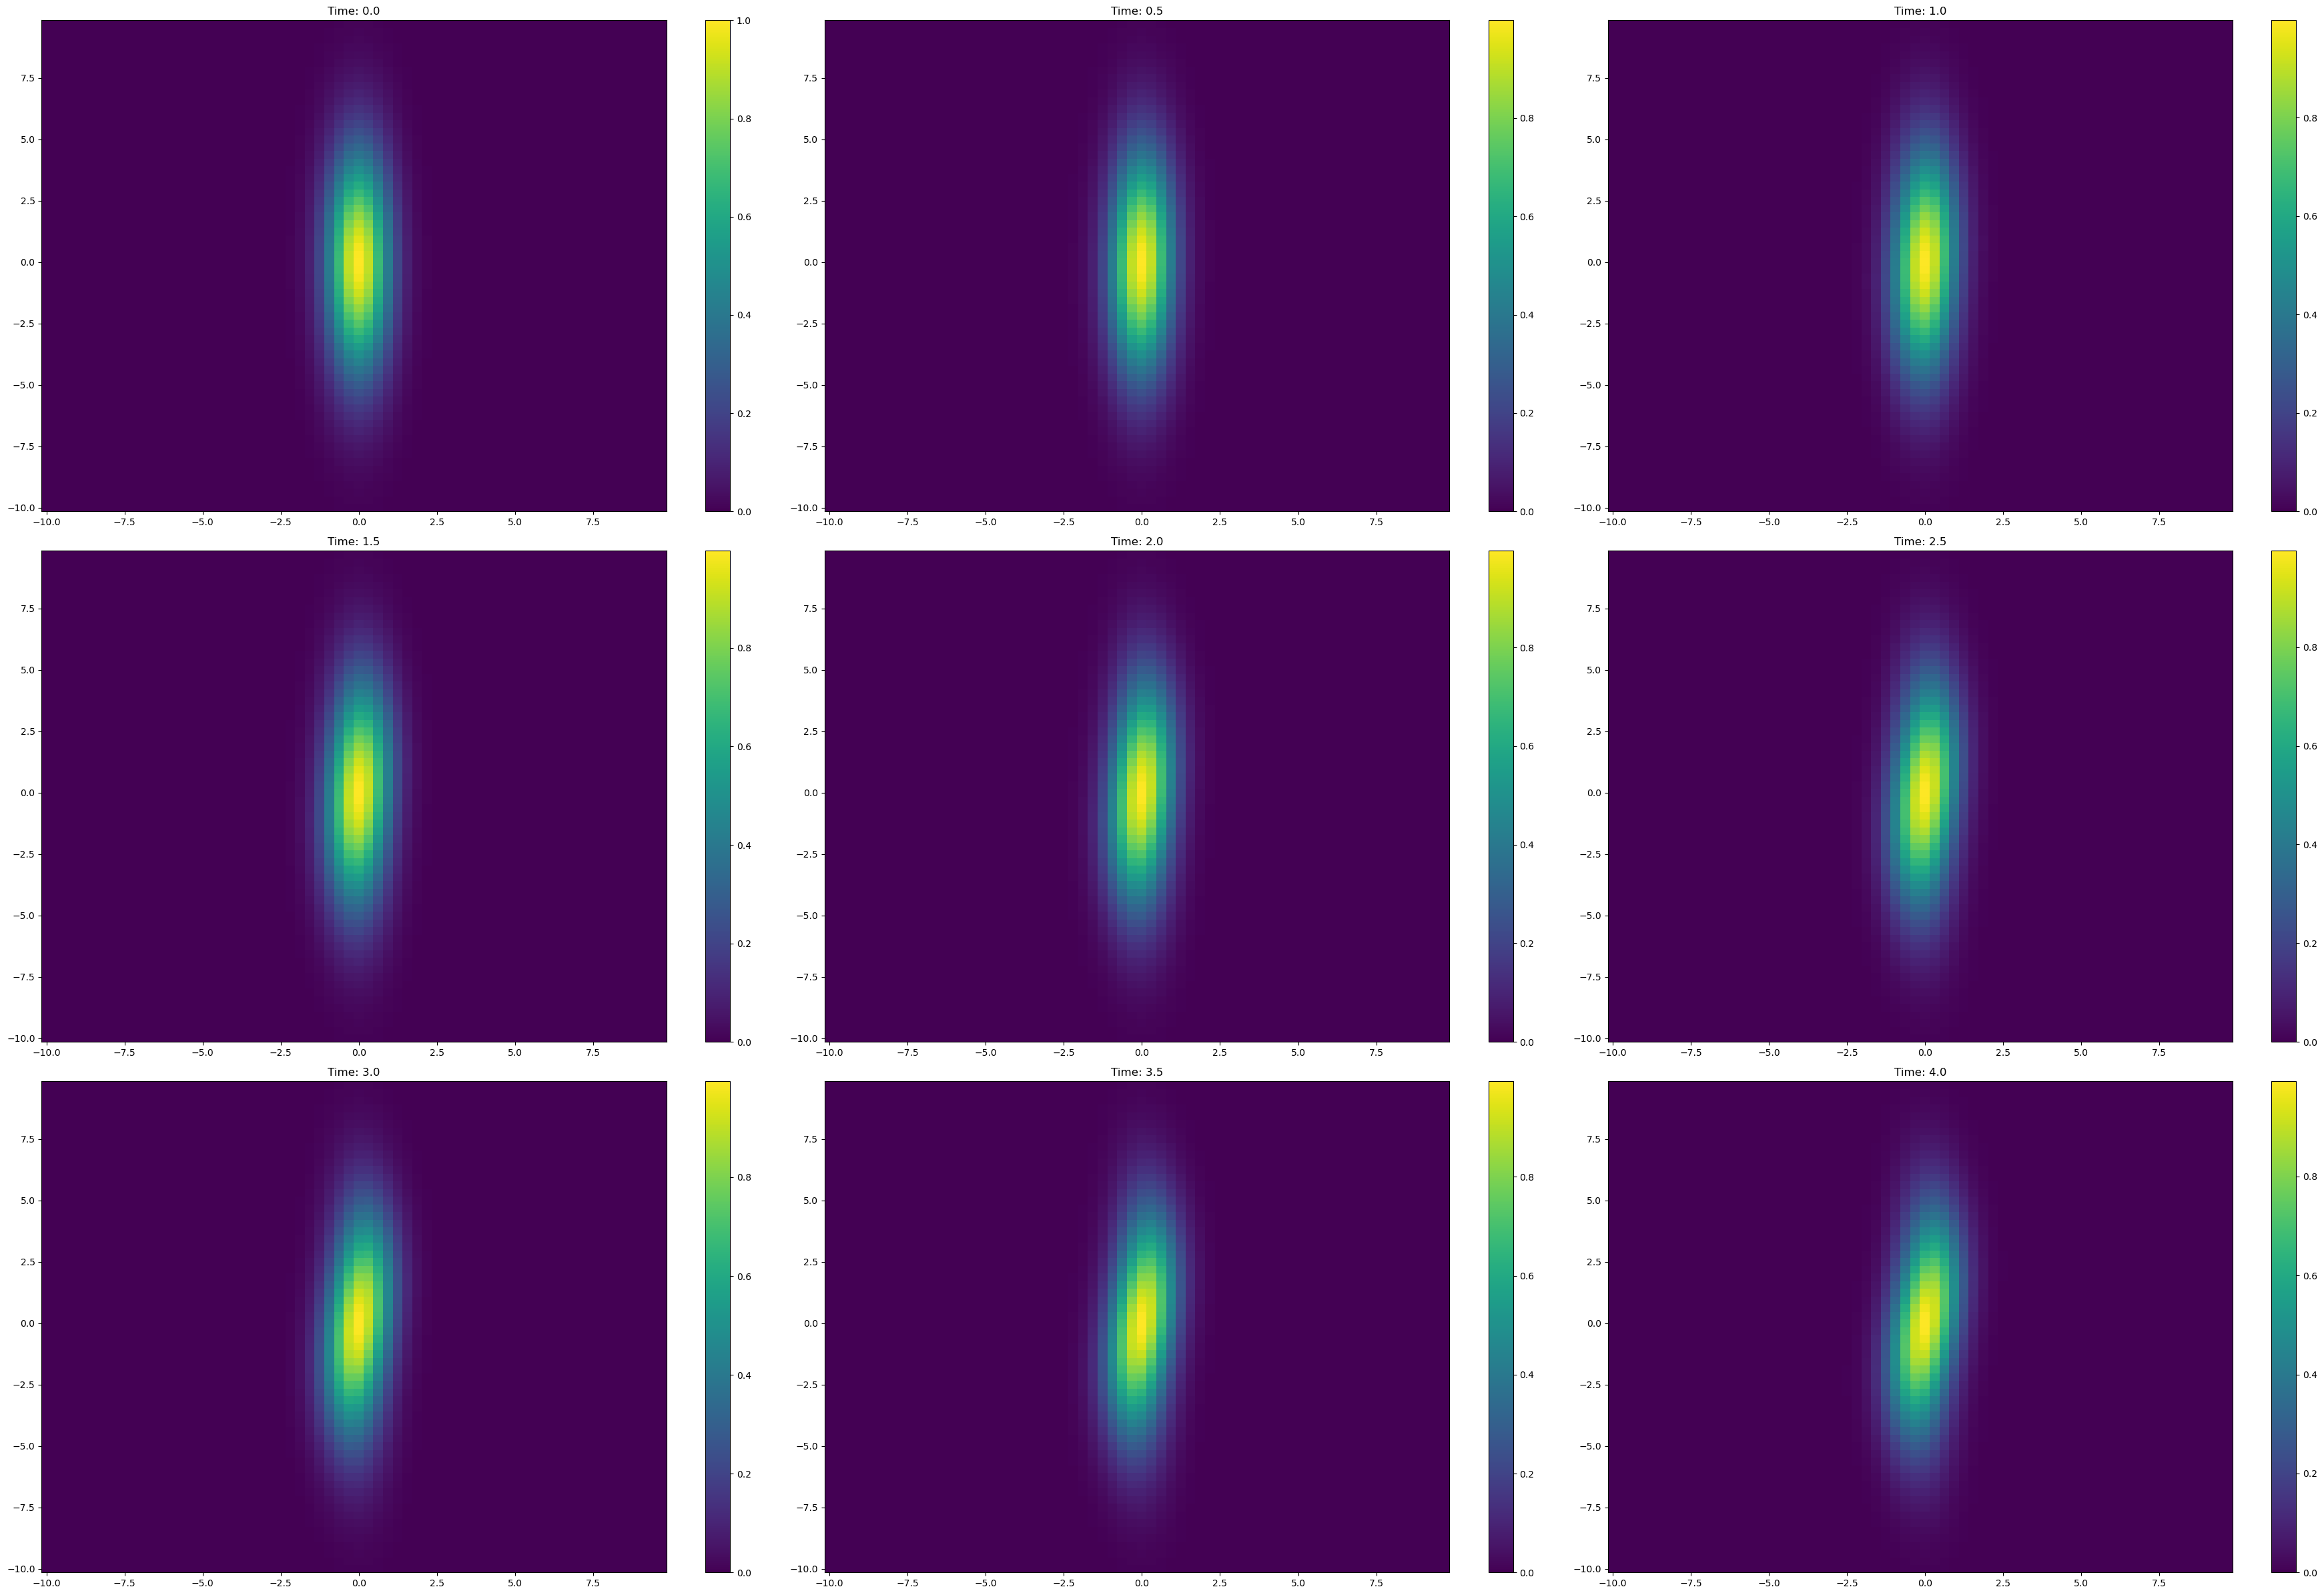

In [111]:
def rhsa(t, omegaflat, A, B, C, nu):
    omega = omegaflat.reshape((N, N))
    omegat = fft2(omega)
    psit = -omegat/K
    psi = ifft2(psit)
    psiflat = np.real(psi.reshape(size))
    rhs = np.real(nu*A.dot(omegaflat) - B.dot(psiflat)*C.dot(omegaflat) + C.dot(psiflat)*B.dot(omegaflat))
    return rhs

sola = solve_ivp(rhsa, timespan, omega0flat, t_eval = times, args=(Ab, B, C, nu))
omegafa = sola.y
plt.figure(figsize = (36, 24))
for ja, tia in enumerate(times):
    omegaia = np.real(omegafa[:size,ja]).reshape((N,N))
    plt.subplot(3, 3, ja + 1)
    plt.pcolor(x, y, omegaia, shading='interp')
    plt.title(f'Time: {tia}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [74]:
Ab = A
Ab[0,0] = 2

/var/folders/0p/2d3480md4n57dj4kyxxyxq6h0000gn/T/ipykernel_38624/3111691349.py:16: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, omegaib1, shading='interp')


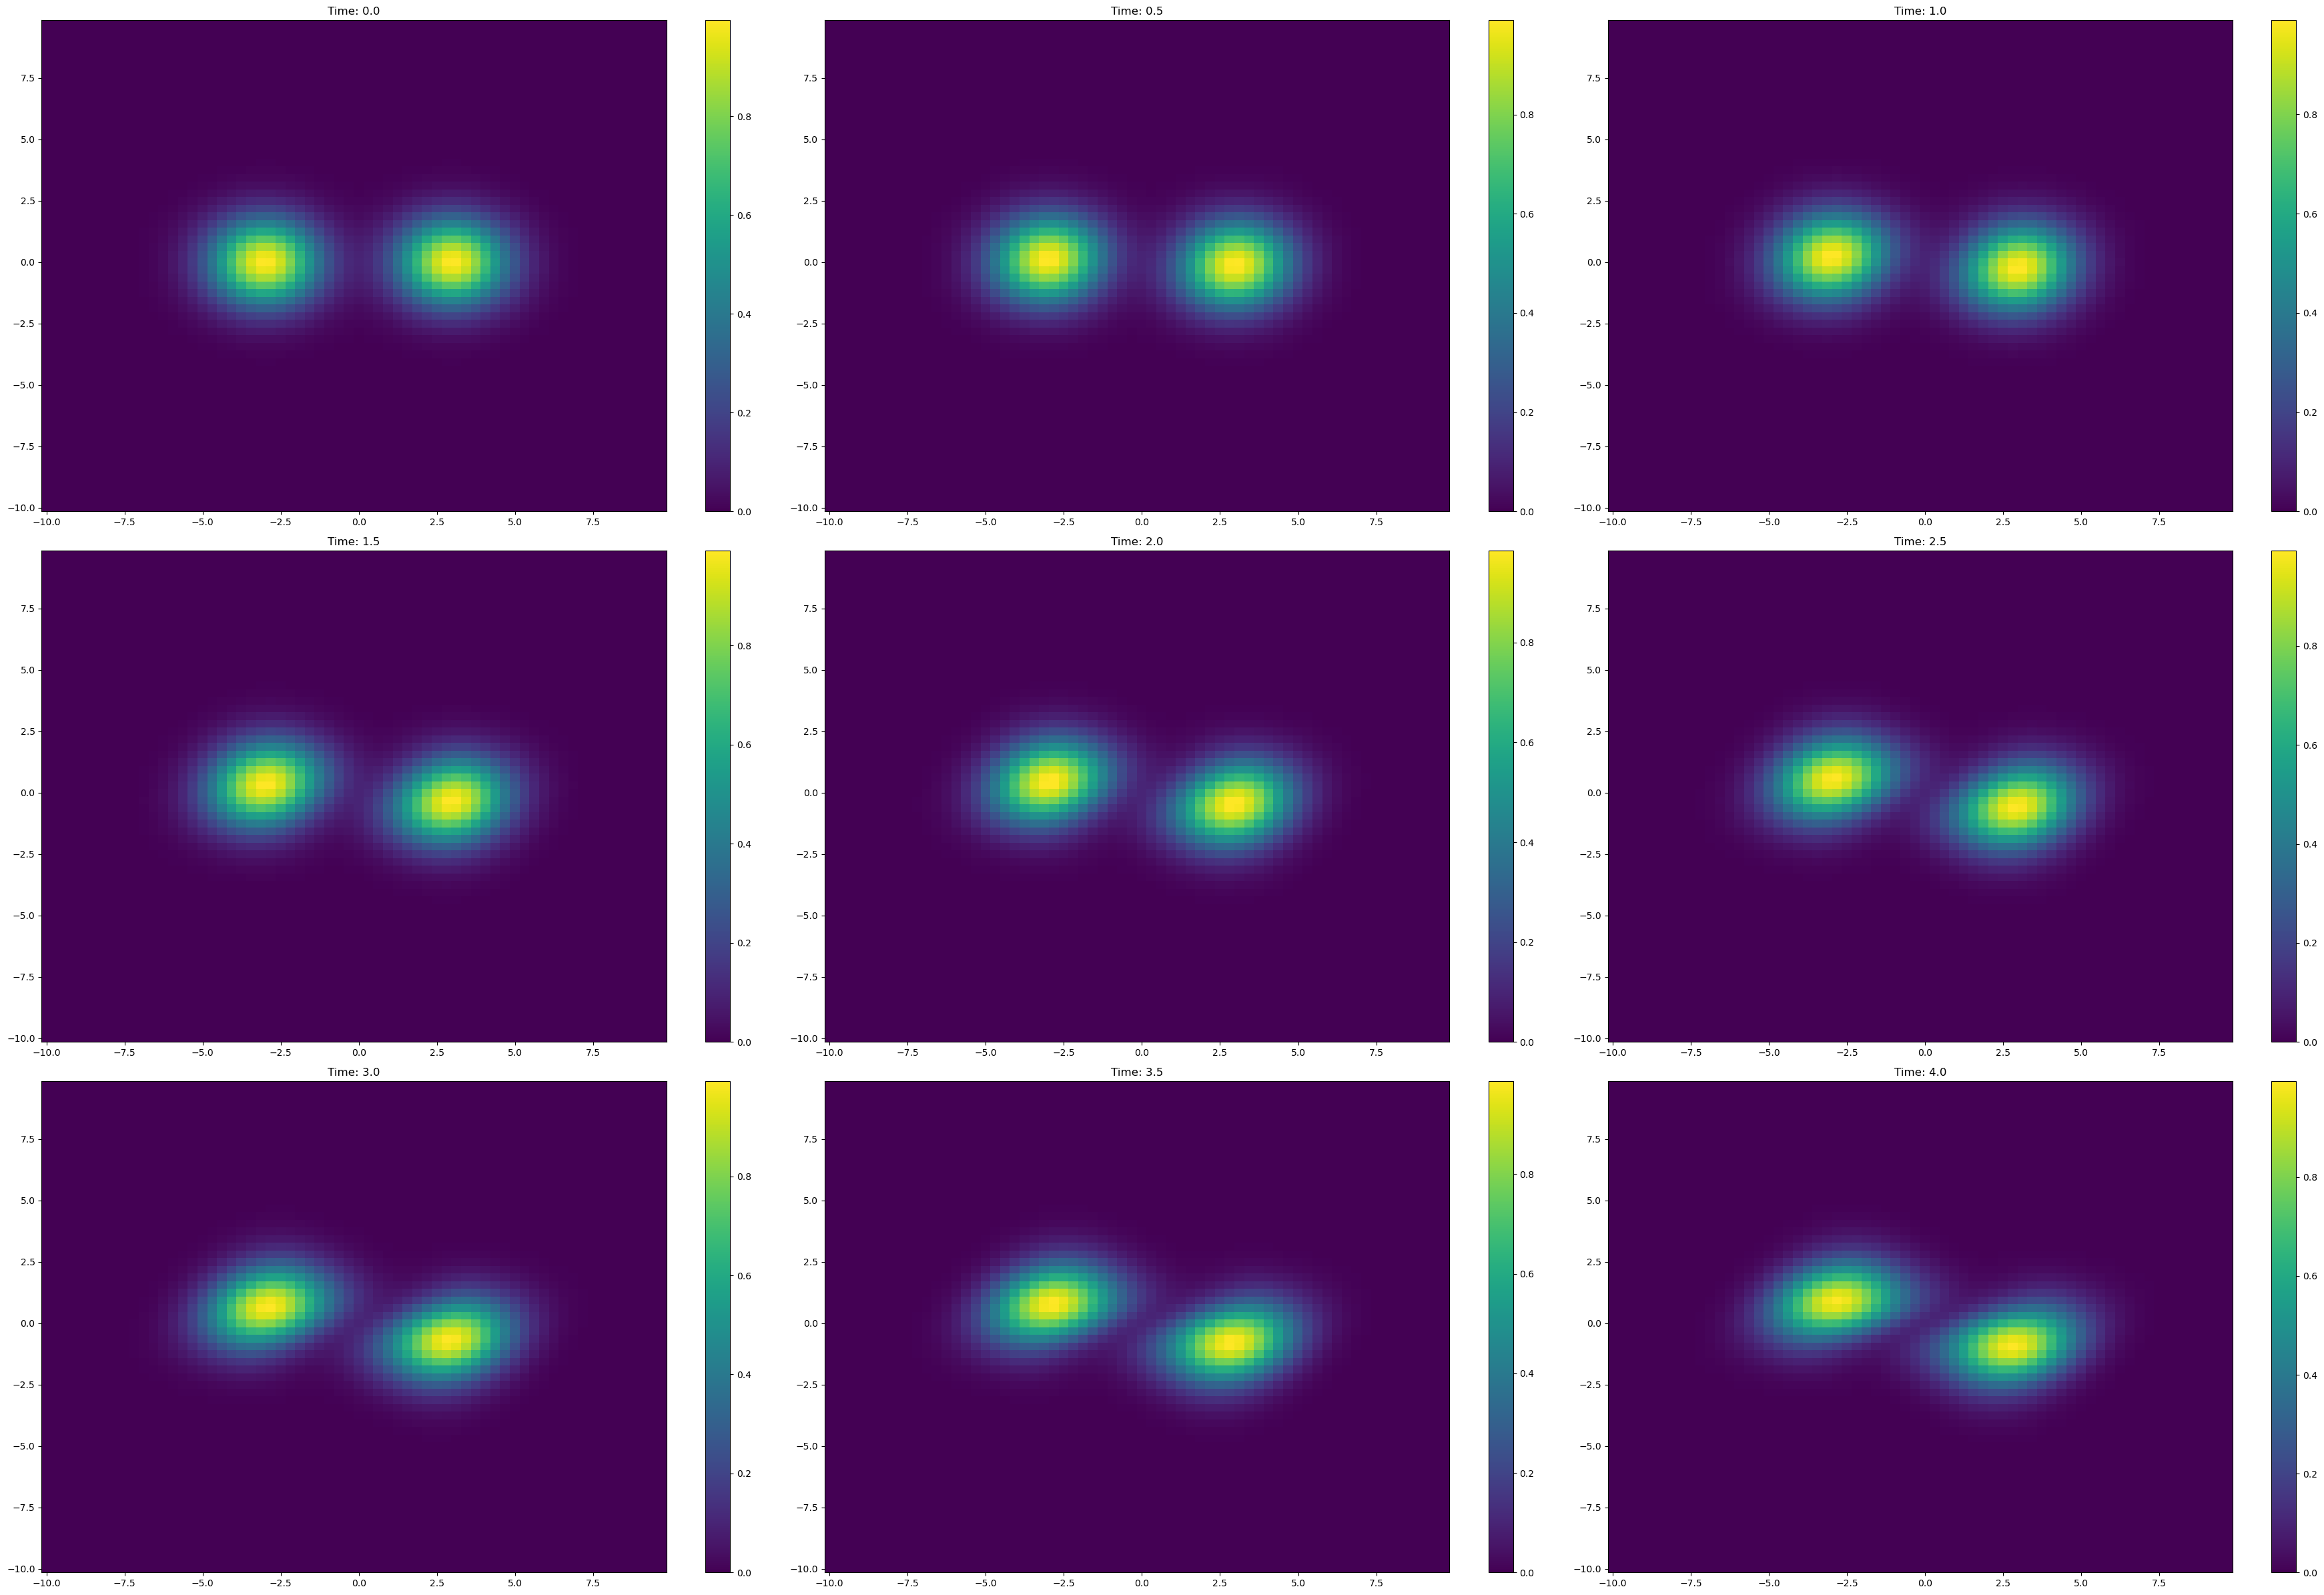

In [109]:
#b1 (A\b)
A2 = np.zeros((4096, 9))
def rhsb1(t, omegaflat, A, B, C, nu):
    psiflat = solve(A, omegaflat)
    rhs = (nu*A.dot(omegaflat) - B.dot(psiflat)*C.dot(omegaflat) + C.dot(psiflat)*B.dot(omegaflat)).reshape(size)
    return rhs

solb1 = solve_ivp(rhsb1, timespan, omega0double.reshape(size), t_eval = times, args=(Ab, B, C, nu))
omegafb1 = solb1.y
frames = []
fig = plt.figure(figsize = (36, 24))
for jb1, tib1 in enumerate(times):
    A2[:size, jb1] = omegafb1[:size,jb1]
    omegaib1 = np.real(omegafb1[:size,jb1]).reshape((N,N))
    plt.subplot(3, 3, jb1 + 1)
    plt.pcolor(x, y, omegaib1, shading='interp')
    plt.title(f'Time: {tib1}')
    plt.colorbar()

plt.tight_layout()
plt.show()

/var/folders/0p/2d3480md4n57dj4kyxxyxq6h0000gn/T/ipykernel_7383/3266044950.py:16: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, omegaib2, shading='interp')


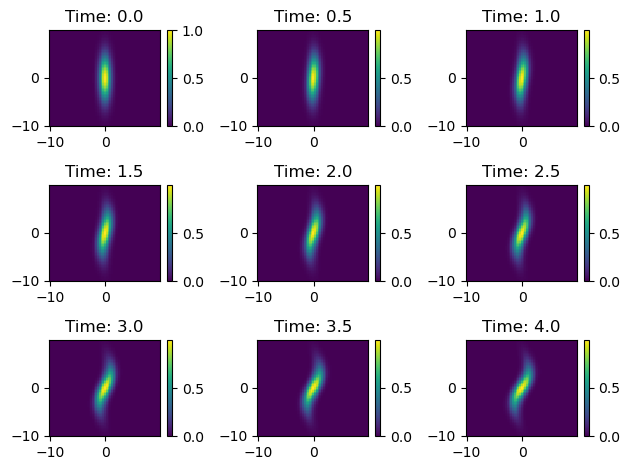

In [166]:
#b2 (LU)
A3 = np.zeros((4096, 9))
Pb2, Lb2, Ub2 = lu(Ab)
def rhsb2(t, omegaflat, A, B, C, P, L, U, nu):
    y0 = solve(L, P.dot(omegaflat))
    psiflat = solve(U, y0)
    rhs = (nu*A.dot(omegaflat) - B.dot(psiflat)*C.dot(omegaflat) + C.dot(psiflat)*B.dot(omegaflat)).reshape(size)
    return rhs

solb2 = solve_ivp(rhsb2, timespan, omega0flat, t_eval = times, args=(Ab, B, C, Pb2, Lb2, Ub2, nu))
omegafb2 = solb2.y
for jb2, tib2 in enumerate(times):
    A3[:size, jb2] = omegafb2[:size,jb2]
    omegaib2 = np.real(omegafb2[:size,jb2]).reshape((N,N))
    plt.subplot(3, 3, jb2 + 1)
    plt.pcolor(x, y, omegaib2, shading='interp')
    plt.title(f'Time: {tib2}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
psiguess = np.zeros((4096,))

/var/folders/0p/2d3480md4n57dj4kyxxyxq6h0000gn/T/ipykernel_7383/768144944.py:13: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, omegaib3, shading='interp')


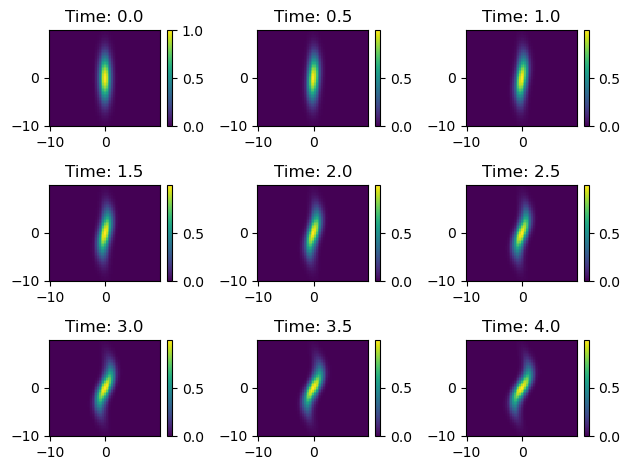

In [174]:
#b3 (bicgstab)
def rhsb3(t, omegaflat, A, B, C, x0, nu):
    psiflat = bicgstab(Ab, omegaflat, x0)[0]
    rhs = (nu*A.dot(omegaflat) - B.dot(psiflat)*C.dot(omegaflat) + C.dot(psiflat)*B.dot(omegaflat)).reshape(size)
    return rhs

solb3 = solve_ivp(rhsb3, timespan, omega0flat, t_eval = times, args=(Ab, B, C, psiguess, nu))
omegafb3 = solb3.y
for jb3, tib3 in enumerate(times):
    omegaib3 = np.real(omegafb3[:size,jb3]).reshape((N,N))
    plt.subplot(3, 3, jb3 + 1)
    plt.pcolor(x, y, omegaib3, shading='interp')
    plt.title(f'Time: {tib3}')
    plt.colorbar()

plt.tight_layout()
plt.show()

/var/folders/0p/2d3480md4n57dj4kyxxyxq6h0000gn/T/ipykernel_7383/816457105.py:12: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, omegaib4, shading='interp')


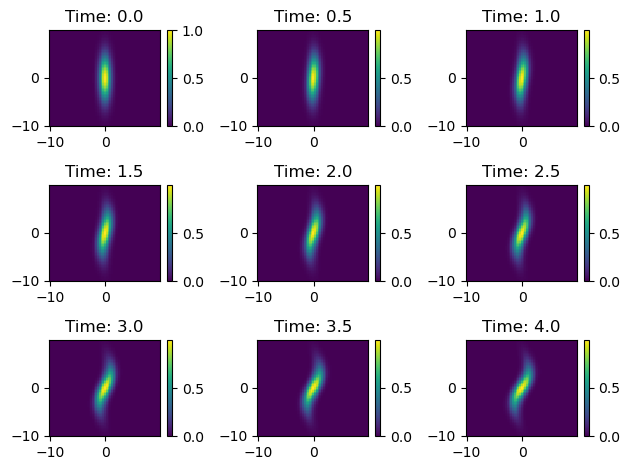

In [176]:
#b4 (gmres)
def rhsb4(t, omegaflat, A, B, C, x0, nu):
    psiflat = gmres(Ab, omegaflat, x0)[0]
    rhs = (nu*A.dot(omegaflat) - B.dot(psiflat)*C.dot(omegaflat) + C.dot(psiflat)*B.dot(omegaflat)).reshape(size)
    return rhs

solb4 = solve_ivp(rhsb4, timespan, omega0flat, t_eval = times, args=(Ab, B, C, psiguess, nu))
omegafb4 = solb4.y
for jb4, tib4 in enumerate(times):
    omegaib4 = np.real(omegafb4[:size,jb4]).reshape((N,N))
    plt.subplot(3, 3, jb4 + 1)
    plt.pcolor(x, y, omegaib4, shading='interp')
    plt.title(f'Time: {tib4}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [104]:
#c
omega0opp = (np.exp((-((X-3)**2)/3)-((Y**2)/3))) - (np.exp((-((X+3)**2)/3)-((Y**2)/3)))
omega0double = (np.exp((-((X-3)**2)/3)-((Y**2)/3))) + (np.exp((-((X+3)**2)/3)-((Y**2)/3)))
omega0collide = (np.exp((-(X**2)/3)-(((Y-7)**2)/3))) - (np.exp((-(X**2)/3)-(((Y+7)**2)/3)))
omega0everywhere = 0.5*(np.exp((-(X**2)/3)-(((Y-7)**2)/3))) - 0.5*(np.exp((-(2*(X+5)**2)/6)-(((Y+6)**2)/6))) + 0.8*(np.exp((-((X-3)**2)/8)-(((Y+3)**2)/8))) - 1.3*(np.exp((-(2*(X-7)**2)/5)-((Y**2)/7))) + (np.exp((-(2*(X+6)**2)/5)-(((Y-3)**2)/10)))

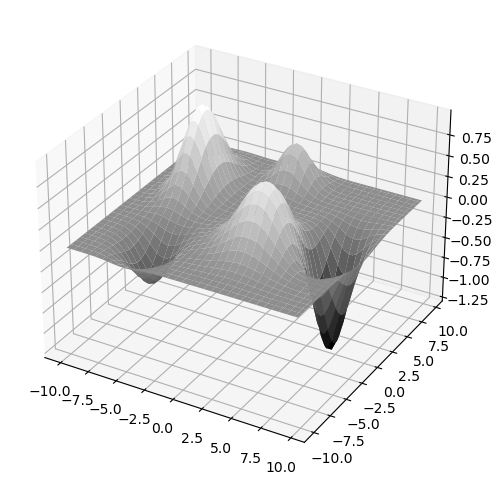

In [105]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y, omega0everywhere, cmap='gray')

/var/folders/0p/2d3480md4n57dj4kyxxyxq6h0000gn/T/ipykernel_38624/3550207005.py:2: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, omega0opp, shading='interp')


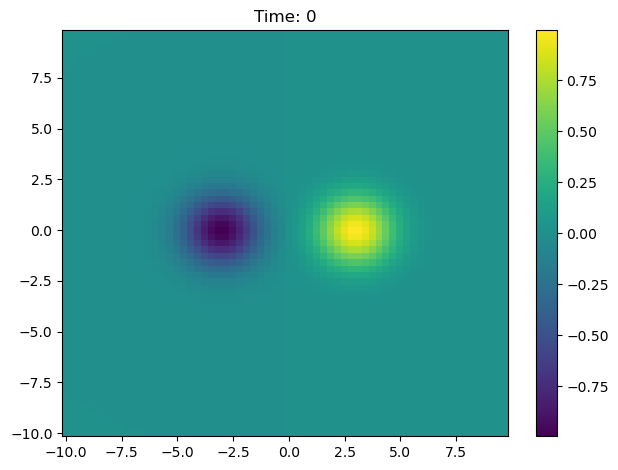

In [22]:
plt.figure()
plt.pcolor(x, y, omega0opp, shading='interp')
plt.title(f'Time: {0}')
plt.colorbar()

plt.tight_layout()
plt.show()

In [108]:
import os
from matplotlib.colors import Normalize
import imageio.v2 as imageio  # Ensure you have imageio installed (`pip install imageio`)

# Create output directory for frames
output_dir = "vorticity_frames"
os.makedirs(output_dir, exist_ok=True)

# Create a colormap for consistency
colormap = 'plasma'

# Loop over time steps and save frames
for j, t in enumerate(times):
    # Transform each column of A1 to position space
    w_position_space = np.real(A2[:, j].reshape((N, N)))
    
    # Plot vorticity in position space
    plt.figure(figsize=(6, 6))
    plt.pcolor(x, y, w_position_space, shading='auto', cmap=colormap, norm=Normalize(vmin=-1, vmax=1))
    plt.title(f"Time: {t:.2f}")
    plt.colorbar(label="Vorticity")
    plt.xlabel("x")
    plt.ylabel("y")
    
    # Save the frame
    frame_path = os.path.join(output_dir, f"frame_{j:04d}.png")
    plt.savefig(frame_path)
    plt.close()

# Combine frames into an animated GIF
gif_path = "vorticity_evolution.gif"
frames = [imageio.imread(os.path.join(output_dir, f)) for f in sorted(os.listdir(output_dir)) if f.endswith(".png")]
imageio.mimsave(gif_path, frames, fps=5)  # Adjust fps as needed

print(f"Animation saved to {gif_path}")
plt.show()

Animation saved to vorticity_evolution.gif
